In [1]:
!pip install bettermdptools
!pip install gymnasium==0.27.1 matplotlib==3.7.1 numpy pandas==2.0.3 seaborn==0.13.2 setuptools==65.5.0 numpy==1.24.3 jax==0.4.13 jaxlib==0.4.13 wget

In [2]:
import gym
import numpy as np
import wget
import time
from bettermdptools.utils.plots import Plots
from bettermdptools.utils.test_env import TestEnv
from bettermdptools.utils.decorators import add_to
import seaborn as sns
import matplotlib.pyplot as plt

ERROR:jax._src.xla_bridge:Jax plugin configuration error: Plugin module %s could not be loaded
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/jax/_src/xla_bridge.py", line 420, in discover_pjrt_plugins
    plugin_module = importlib.import_module(plugin_module_name)
                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/importlib/__init__.py", line 126, in import_module
    return _bootstrap._gcd_import(name[level:], package, level)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<frozen importlib._bootstrap>", line 1204, in _gcd_import
  File "<frozen importlib._bootstrap>", line 1176, in _find_and_load
  File "<frozen importlib._bootstrap>", line 1147, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 690, in _load_unlocked
  File "<frozen importlib._bootstrap_external>", line 940, in exec_module
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_r

##BetterMDPtools

###Planner

In [3]:
"""
Author: Miguel Morales
BSD 3-Clause License

Copyright (c) 2018, Miguel Morales
All rights reserved.
https://github.com/mimoralea/gdrl/blob/master/LICENSE
"""

"""
modified by: John Mansfield

documentation added by: Gagandeep Randhawa
"""

"""
Class that contains functions related to planning algorithms (Value Iteration, Policy Iteration).
Planner init expects a reward and transitions matrix P, which is nested dictionary gym style discrete environment
where P[state][action] is a list of tuples (probability, next state, reward, terminal).

Model-based learning algorithms: Value Iteration and Policy Iteration
"""

import warnings

import numpy as np


class Planner:
    def __init__(self, P):
        """
        Initializes the Planner class.

        Parameters
        ----------
        P : dict
            Transition probability matrix where P[state][action] is a list of tuples
            (probability, next state, reward, terminal).
        """
        self.P = P

    def value_iteration(self, gamma=1.0, n_iters=1000, theta=1e-10, dtype=np.float32):
        """
        Value Iteration algorithm.

        Parameters
        ----------
        gamma : float, optional
            Discount factor, by default 1.0.
        n_iters : int, optional
            Number of iterations, by default 1000.
        theta : float, optional
            Convergence criterion for value iteration, by default 1e-10.

        Returns
        -------
        tuple
            V : np.ndarray
                State values array.
            V_track : np.ndarray
                Log of V(s) for each iteration.
            pi : dict
                Policy mapping states to actions.
        """
        V = np.zeros(len(self.P), dtype=dtype)
        V_track = np.zeros((n_iters, len(self.P)), dtype=dtype)
        i = 0
        converged = False
        while i < n_iters - 1 and not converged:
            i += 1
            Q = np.zeros((len(self.P), len(self.P[0])), dtype=dtype)
            for s in range(len(self.P)):
                for a in range(len(self.P[s])):
                    for prob, next_state, reward, done in self.P[s][a]:
                        Q[s][a] += prob * (reward + gamma * V[next_state] * (not done))
            if np.max(np.abs(V - np.max(Q, axis=1))) < theta:
                converged = True
            V = np.max(Q, axis=1)
            V_track[i] = V

        if not converged:
            warnings.warn("Max iterations reached before convergence.  Check n_iters.")

        pi = {s: a for s, a in enumerate(np.argmax(Q, axis=1))}
        return V, V_track, pi

    def value_iteration_vectorized(
        self, gamma=1.0, n_iters=1000, theta=1e-10, dtype=np.float32
    ):
        """
        Vectorized Value Iteration algorithm.

        Parameters
        ----------
        gamma : float
            Discount factor

        n_iters : int
            Number of iterations

        theta : float
            Convergence criterion for value iteration.
            State values are considered to be converged when the maximum difference between new and previous state values is less than theta.
            Stops at n_iters or theta convergence - whichever comes first.

        Returns
        -------
        tuple
            V : np.ndarray
                State values array.
            V_track : np.ndarray
                Log of V(s) for each iteration.
            pi : dict
                Policy mapping states to actions.
        """
        S = len(self.P)
        A = len(self.P[0])

        max_K = max(len(self.P[s][a]) for s in range(S) for a in range(A))

        prob_array = np.zeros((S, A, max_K), dtype=dtype)
        next_state_array = np.zeros((S, A, max_K), dtype=np.int32)
        reward_array = np.zeros((S, A, max_K), dtype=dtype)
        done_array = np.zeros((S, A, max_K), dtype=bool)
        mask_array = np.zeros((S, A, max_K), dtype=bool)

        for s in range(S):
            for a in range(A):
                transitions = self.P[s][a]
                for k, (prob, next_state, reward, done) in enumerate(transitions):
                    prob_array[s, a, k] = prob
                    next_state_array[s, a, k] = next_state
                    reward_array[s, a, k] = reward
                    done_array[s, a, k] = done
                    mask_array[s, a, k] = True

        V = np.zeros(S, dtype=dtype)
        V_track = np.zeros((n_iters, S), dtype=dtype)
        converged = False
        # Simpler way to handle done states
        not_done_array = 1 - done_array
        i = 0
        converged = False
        while i < n_iters - 1 and not converged:
            i += 1
            Q = np.sum(
                prob_array
                * (reward_array + gamma * V[next_state_array] * not_done_array)
                * mask_array,
                axis=2,
            )
            V_new = np.max(Q, axis=1)

            if np.max(np.abs(V - V_new)) < theta:
                converged = True

            V = V_new
            V_track[i] = V

        if not converged:
            warnings.warn("Max iterations reached before convergence. Check n_iters.")

        return V, V_track, dict(enumerate(np.argmax(Q, axis=1)))

    def policy_iteration(self, gamma=1.0, n_iters=50, theta=1e-10, dtype=np.float32):
        """
        Policy Iteration algorithm.

        Parameters
        ----------
        gamma : float, optional
            Discount factor, by default 1.0.
        n_iters : int, optional
            Number of iterations, by default 50.
        theta : float, optional
            Convergence criterion for policy evaluation, by default 1e-10.

        Returns
        -------
        tuple
            V : np.ndarray
                State values array.
            V_track : np.ndarray
                Log of V(s) for each iteration.
            pi : dict
                Policy mapping states to actions.
        """
        random_actions = np.random.choice(tuple(self.P[0].keys()), len(self.P))

        pi = {s: a for s, a in enumerate(random_actions)}
        # initial V to give to `policy_evaluation` for the first time
        V = np.zeros(len(self.P), dtype=dtype)
        V_track = np.zeros((n_iters, len(self.P)), dtype=dtype)
        i = 0
        converged = False
        while i < n_iters - 1 and not converged:
            i += 1
            old_pi = pi
            V = self.policy_evaluation(pi, V, gamma=gamma, theta=theta, dtype=dtype)
            V_track[i] = V
            pi = self.policy_improvement(V, gamma=gamma, dtype=dtype)
            if old_pi == pi:
                converged = True

        if not converged:
            warnings.warn("Max iterations reached before convergence.  Check n_iters.")
        return V, V_track, pi

    def policy_evaluation(self, pi, prev_V, gamma=1.0, theta=1e-10, dtype=np.float32):
        """
        Policy Evaluation algorithm.

        Parameters
        ----------
        pi : dict
            Policy mapping states to actions.
        prev_V : np.ndarray
            Previous state values array.
        gamma : float, optional
            Discount factor, by default 1.0.
        theta : float, optional
            Convergence criterion, by default 1e-10.

        Returns
        -------
        np.ndarray
            State values array.
        """
        while True:
            V = np.zeros(len(self.P), dtype=dtype)
            for s in range(len(self.P)):
                for prob, next_state, reward, done in self.P[s][pi[s]]:
                    V[s] += prob * (reward + gamma * prev_V[next_state] * (not done))
            if np.max(np.abs(prev_V - V)) < theta:
                break
            prev_V = V.copy()
        return V

    def policy_improvement(self, V, gamma=1.0, dtype=np.float32):
        """
        Policy Improvement algorithm.

        Parameters
        ----------
        V : np.ndarray
            State values array.
        gamma : float, optional
            Discount factor, by default 1.0.

        Returns
        -------
        dict
            Policy mapping states to actions.
        """
        Q = np.zeros((len(self.P), len(self.P[0])), dtype=dtype)
        for s in range(len(self.P)):
            for a in range(len(self.P[s])):
                for prob, next_state, reward, done in self.P[s][a]:
                    Q[s][a] += prob * (reward + gamma * V[next_state] * (not done))

        return dict(enumerate(np.argmax(Q, axis=1)))

###RL

In [4]:
"""
Author: Miguel Morales
BSD 3-Clause License

Copyright (c) 2018, Miguel Morales
All rights reserved.
https://github.com/mimoralea/gdrl/blob/master/LICENSE
"""

"""
modified by: John Mansfield

documentation added by: Gagandeep Randhawa
"""

"""
Class that contains functions related to reinforcement learning algorithms. RL init expects an OpenAI environment (env).

Model-free learning algorithms: Q-Learning and SARSA
work out of the box with any gymnasium environments that
have single discrete valued state spaces, like frozen lake. A lambda function
is required to convert state spaces not in this format.
"""

import warnings

import numpy as np
from tqdm.auto import tqdm

from bettermdptools.utils.callbacks import MyCallbacks


class RL:
    def __init__(self, env):
        self.env = env
        self.callbacks = MyCallbacks()
        self.render = False
        # Explanation of lambda:
        # def select_action(state, Q, epsilon):
        #   if np.random.random() > epsilon:
        #       max_val = np.max(Q[state])
        #       indxs_selector = np.isclose(Q[state], max_val)
        #       indxs = np.arange(len(Q[state]))[indxs_selector]
        #       return np.random.choice(indxs)
        #   else:
        #       return np.random.randint(len(Q[state]))
        self.select_action = (
            lambda state, Q, epsilon: np.random.choice(
                np.arange(len(Q[state]))[np.isclose(Q[state], np.max(Q[state]))]
            )
            if np.random.random() > epsilon
            else np.random.randint(len(Q[state]))
        )

    @staticmethod
    def decay_schedule(
        init_value, min_value, decay_ratio, max_steps, log_start=-2, log_base=10
    ):
        """
        Generates a decay schedule for a given initial value.

        Parameters
        ----------
        init_value : float
            Initial value of the quantity being decayed.
        min_value : float
            Minimum value init_value is allowed to decay to.
        decay_ratio : float
            The exponential factor exp(decay_ratio).
        max_steps : int
            Max iteration steps for decaying init_value.
        log_start : float, optional
            Starting value of the decay sequence, by default -2.
        log_base : float, optional
            Base of the log space, by default 10.

        Returns
        -------
        np.ndarray
            Decay values where values[i] is the value used at i-th step.
        """
        decay_steps = int(max_steps * decay_ratio)
        rem_steps = max_steps - decay_steps
        values = np.logspace(log_start, 0, decay_steps, base=log_base, endpoint=True)[
            ::-1
        ]
        values = (values - values.min()) / (values.max() - values.min())
        values = (init_value - min_value) * values + min_value
        values = np.pad(values, (0, rem_steps), "edge")
        return values

    def q_learning(
        self,
        nS=None,
        nA=None,
        convert_state_obs=lambda state: state,
        gamma=0.99,
        init_alpha=0.5,
        min_alpha=0.01,
        alpha_decay_ratio=0.5,
        init_epsilon=1.0,
        min_epsilon=0.1,
        epsilon_decay_ratio=0.9,
        n_episodes=10000,
    ):
        """
        Q-Learning algorithm.

        Parameters
        ----------
        nS : int, optional
            Number of states, by default None.
        nA : int, optional
            Number of available actions, by default None.
        convert_state_obs : function, optional
            Converts state into an integer, by default lambda state: state.
        gamma : float, optional
            Discount factor, by default 0.99.
        init_alpha : float, optional
            Initial learning rate, by default 0.5.
        min_alpha : float, optional
            Minimum learning rate, by default 0.01.
        alpha_decay_ratio : float, optional
            Decay schedule of learning rate for future iterations, by default 0.5.
        init_epsilon : float, optional
            Initial epsilon value for epsilon greedy strategy, by default 1.0.
        min_epsilon : float, optional
            Minimum epsilon, by default 0.1.
        epsilon_decay_ratio : float, optional
            Decay schedule of epsilon for future iterations, by default 0.9.
        n_episodes : int, optional
            Number of episodes for the agent, by default 10000.

        Returns
        -------
        tuple
            Q : np.ndarray
                Final action-value function Q(s,a).
            V : np.ndarray
                State values array.
            pi : dict
                Policy mapping states to actions.
            Q_track : np.ndarray
                Log of Q(s,a) for each episode.
            pi_track : list
                Log of complete policy for each episode.
            rewards : np.ndarray
                Rewards obtained in each episode.
        """
        if nS is None:
            nS = self.env.observation_space.n
        if nA is None:
            nA = self.env.action_space.n
        pi_track = []
        Q = np.zeros((nS, nA), dtype=np.float32)
        Q_track = np.zeros((n_episodes, nS, nA), dtype=np.float32)
        alphas = RL.decay_schedule(init_alpha, min_alpha, alpha_decay_ratio, n_episodes)
        epsilons = RL.decay_schedule(
            init_epsilon, min_epsilon, epsilon_decay_ratio, n_episodes
        )
        rewards = np.zeros(n_episodes, dtype=np.float32)
        for e in tqdm(range(n_episodes), leave=False):
            self.callbacks.on_episode_begin(self)
            self.callbacks.on_episode(self, episode=e)
            state, info = self.env.reset()
            done = False
            state = convert_state_obs(state)
            total_reward = 0
            while not done:
                if self.render:
                    warnings.warn(
                        "Occasional render has been deprecated by openAI.  Use test_env.py to render."
                    )
                action = self.select_action(state, Q, epsilons[e])
                next_state, reward, terminated, truncated, _ = self.env.step(action)
                if truncated:
                    warnings.warn(
                        "Episode was truncated.  TD target value may be incorrect."
                    )
                done = terminated or truncated
                self.callbacks.on_env_step(self)
                next_state = convert_state_obs(next_state)
                td_target = reward + gamma * Q[next_state].max() * (not done)
                td_error = td_target - Q[state][action]
                Q[state][action] = Q[state][action] + alphas[e] * td_error
                state = next_state
                total_reward += reward
            rewards[e] = total_reward
            Q_track[e] = Q
            pi_track.append(np.argmax(Q, axis=1))
            self.render = False
            self.callbacks.on_episode_end(self)

        V = np.max(Q, axis=1)

        pi = {s: a for s, a in enumerate(np.argmax(Q, axis=1))}
        return Q, V, pi, Q_track, pi_track, rewards

    def sarsa(
        self,
        nS=None,
        nA=None,
        convert_state_obs=lambda state: state,
        gamma=0.99,
        init_alpha=0.5,
        min_alpha=0.01,
        alpha_decay_ratio=0.5,
        init_epsilon=1.0,
        min_epsilon=0.1,
        epsilon_decay_ratio=0.9,
        n_episodes=10000,
    ):
        """
        SARSA algorithm.

        Parameters
        ----------
        nS : int, optional
            Number of states, by default None.
        nA : int, optional
            Number of available actions, by default None.
        convert_state_obs : function, optional
            Converts state into an integer, by default lambda state: state.
        gamma : float, optional
            Discount factor, by default 0.99.
        init_alpha : float, optional
            Initial learning rate, by default 0.5.
        min_alpha : float, optional
            Minimum learning rate, by default 0.01.
        alpha_decay_ratio : float, optional
            Decay schedule of learning rate for future iterations, by default 0.5.
        init_epsilon : float, optional
            Initial epsilon value for epsilon greedy strategy, by default 1.0.
        min_epsilon : float, optional
            Minimum epsilon, by default 0.1.
        epsilon_decay_ratio : float, optional
            Decay schedule of epsilon for future iterations, by default 0.9.
        n_episodes : int, optional
            Number of episodes for the agent, by default 10000.

        Returns
        -------
        tuple
            Q : np.ndarray
                Final action-value function Q(s,a).
            V : np.ndarray
                State values array.
            pi : dict
                Policy mapping states to actions.
            Q_track : np.ndarray
                Log of Q(s,a) for each episode.
            pi_track : list
                Log of complete policy for each episode.
            rewards : np.ndarray
                Rewards obtained in each episode.
        """
        if nS is None:
            nS = self.env.observation_space.n
        if nA is None:
            nA = self.env.action_space.n
        pi_track = []
        Q = np.zeros((nS, nA), dtype=np.float32)
        Q_track = np.zeros((n_episodes, nS, nA), dtype=np.float32)
        rewards = np.zeros(n_episodes, dtype=np.float32)
        alphas = RL.decay_schedule(init_alpha, min_alpha, alpha_decay_ratio, n_episodes)
        epsilons = RL.decay_schedule(
            init_epsilon, min_epsilon, epsilon_decay_ratio, n_episodes
        )

        for e in tqdm(range(n_episodes), leave=False):
            self.callbacks.on_episode_begin(self)
            self.callbacks.on_episode(self, episode=e)
            state, info = self.env.reset()
            done = False
            state = convert_state_obs(state)
            action = self.select_action(state, Q, epsilons[e])
            total_reward = 0
            while not done:
                if self.render:
                    warnings.warn(
                        "Occasional render has been deprecated by openAI.  Use test_env.py to render."
                    )
                next_state, reward, terminated, truncated, _ = self.env.step(action)
                if truncated:
                    warnings.warn(
                        "Episode was truncated.  TD target value may be incorrect."
                    )
                done = terminated or truncated
                self.callbacks.on_env_step(self)
                next_state = convert_state_obs(next_state)
                next_action = self.select_action(next_state, Q, epsilons[e])
                td_target = reward + gamma * Q[next_state][next_action] * (not done)
                td_error = td_target - Q[state][action]
                Q[state][action] = Q[state][action] + alphas[e] * td_error
                state, action = next_state, next_action
                total_reward += reward
            rewards[e] = total_reward
            Q_track[e] = Q
            pi_track.append(np.argmax(Q, axis=1))
            self.render = False
            self.callbacks.on_episode_end(self)

        V = np.max(Q, axis=1)

        pi = {s: a for s, a in enumerate(np.argmax(Q, axis=1))}
        return Q, V, pi, Q_track, pi_track, rewards

###BlackjackWrapper
Modified to use downloaded transition/reward matrix to initialize P

In [5]:
"""
Author: John Mansfield
BSD 3-Clause License

# Transitions and rewards matrix from: https://github.com/rhalbersma/gym-blackjack-v1
#    Observations:
#   There are 29 * 10 = 290 discrete observable states:
#    29 player hands: H4-H21, S12-S21, BJ (0-28)
#     H4   =  0
#     H5   =  1
#     H6   =  2
#     H7   =  3
#     H8   =  4
#     H9   =  5
#     H10  =  6
#     H11  =  7
#     H12  =  8
#     H13  =  9
#     H14  = 10
#     H15  = 11
#     H16  = 12
#     H17  = 13
#     H18  = 14
#     H19  = 15
#     H20  = 16
#     H21  = 17
#     S12  = 18
#     S13  = 19
#     S14  = 20
#     S15  = 21
#     S16  = 22
#     S17  = 23
#     S18  = 24
#     S19  = 25
#     S20  = 26
#     S21  = 27
#     BJ   = 28
#    Concatenated with 10 dealer cards: 2-9, T, A (0-9)
#     _2 = 0
#     _3 = 1
#     _4 = 2
#     _5 = 3
#     _6 = 4
#     _7 = 5
#     _8 = 6
#     _9 = 7
#     _T = 8 # 10, J, Q, K are all denoted as T
#     _A = 9
"""

import os
import pickle

import gymnasium as gym


class CustomTransformObservation(gym.ObservationWrapper):
    def __init__(self, env, func, observation_space):
        """
        Helper class that modifies the observation space. The v26 gymnasium TransformObservation wrapper does not
        accept an observation_space parameter, which is needed in order to match the lambda conversion (tuple->int).
        Instead, we subclass gym.ObservationWrapper (parent class of gym.TransformObservation)
        to set both the conversion function and new observation space.

        Parameters
        ----------
        env : gymnasium.Env
            Blackjack base environment to be wrapped.
        func : lambda
            Function that converts the observation.
        observation_space : gymnasium.spaces.Space
            New observation space.
        """
        super().__init__(env)
        if observation_space is not None:
            self.observation_space = observation_space
        self.func = func

    def observation(self, observation):
        """
        Applies a function to the observation received from the environment's step function,
        which is passed back to the user.

        Parameters
        ----------
        observation : Tuple
            Blackjack base environment observation tuple.

        Returns
        -------
        int
            The converted observation (290 discrete observable states).
        """
        return self.func(observation)


class BlackjackWrapper(gym.Wrapper):
    def __init__(self, env):
        """
        Blackjack wrapper that modifies the observation space and creates a transition/reward matrix P.

        Parameters
        ----------
        env : gymnasium.Env
            Blackjack base environment.

        Explanation of _transform_obs lambda:
        Lambda function assigned to the variable `self._convert_state_obs` takes parameter, `state` and
        converts the input into a compact single integer value by concatenating player hand with dealer card.
        See comments above for further information.
        """
        self._transform_obs = lambda obs: (
            int(f"{28}{(obs[1] - 2) % 10}")
            if (obs[0] == 21 and obs[2])
            else int(f"{27}{(obs[1] - 2) % 10}")
            if (obs[0] == 21 and not obs[2])
            else int(f"{obs[0] + 6}{(obs[1] - 2) % 10}")
            if obs[2]
            else int(f"{obs[0] - 4}{(obs[1] - 2) % 10}")
        )
        env = CustomTransformObservation(
            env, self._transform_obs, gym.spaces.Discrete(290)
        )
        super().__init__(env)
        # Loading transition/reward matrix
        file_name = "/content/blackjack-envP.pickle"
        with open(file_name, "rb") as f:
            self._P = pickle.load(f)

    @property
    def P(self):
        """
        Returns
        -------
        dict
            Transition/reward matrix.
        """
        return self._P

    @property
    def transform_obs(self):
        """
        Returns
        -------
        lambda
            Function that converts the observation.
        """
        return self._transform_obs

In [6]:
url = 'https://github.com/jlm429/bettermdptools/raw/master/bettermdptools/envs/blackjack-envP.pickle'
file_path = 'blackjack-envP.pickle'
wget.download(url, file_path)

'blackjack-envP.pickle'

# Blackjack
Planner __init__ expects a reward and transition matrix P, which is a nested dictionary
[OpenAI Gym](https://gymnasium.farama.org/) style discrete environment where
P[state][action] is a list of tuples (probability, next state, reward, terminal).

The gym blackjack environment does not include this matrix, so we'll use the BlackjackWrapper class to create a wrapped gym environment, which modifies the observation space and includes P.  

Source code from https://github.com/jlm429/bettermdptools/blob/master/bettermdptools/envs/blackjack_wrapper.py

###Get transition/reward matrix

##Algorithms

In [7]:
rng = 42  # Choose any integer as your seed
np.random.seed(rng)
base_env = gym.make('Blackjack-v1', render_mode=None)
base_env.action_space.seed(rng) # Seed action space
base_env.observation_space.seed(rng) #Seed observation space
blackjack = BlackjackWrapper(base_env)

###Value Iteration

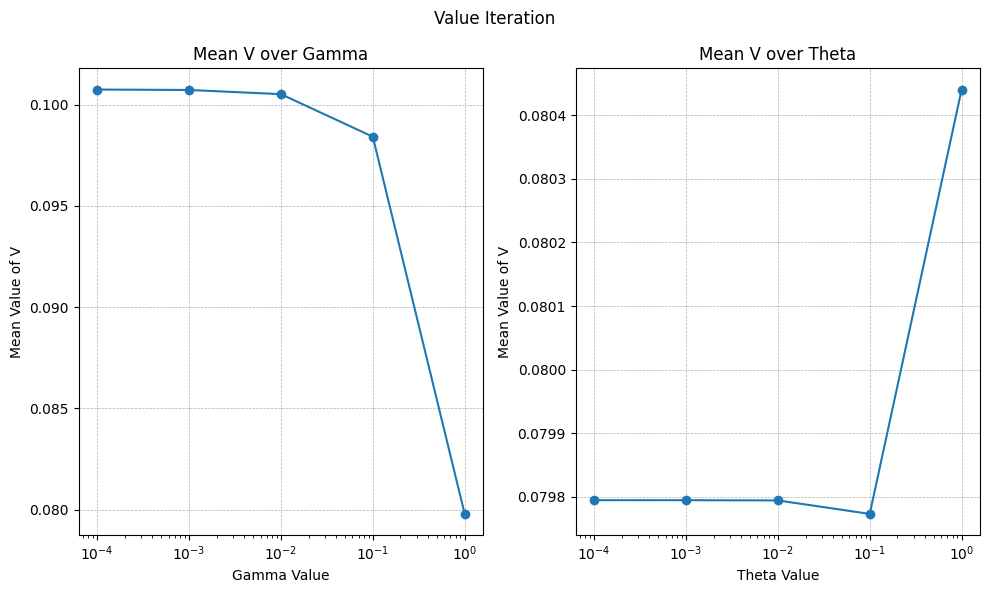

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(10, 6))
fig.suptitle('Value Iteration')

### Gamma graph
# Define gammas
gammas = {
    0.0001: "blue",
    0.001: "orange",
    0.01: "green",
    0.1: "red",
    1.0: "purple",
}

gamma_final_mean_v = {}

for g in gammas.keys():
    bj_vi_V_value, _, _ = Planner(blackjack.P).value_iteration(gamma=g)
    gamma_final_mean_v[g] = np.mean(bj_vi_V_value)

# Plotting the final mean V for each gamma
axs[0].plot(gamma_final_mean_v.keys(), gamma_final_mean_v.values(), marker='o')
axs[0].set_title('Mean V over Gamma')
axs[0].set_xlabel('Gamma Value')
axs[0].set_ylabel('Mean Value of V')
axs[0].set_xscale('log')
axs[0].grid(True, which="major", linestyle='--', linewidth=0.5)

### Theta graph
# Define thetas
thetas = {
    0.0001: "blue",
    0.001: "orange",
    0.01: "green",
    0.1: "red",
    1.0: "purple"
}

theta_final_mean_v = {}

for t in thetas.keys():
    bj_vi_V_value, _, _ = Planner(blackjack.P).value_iteration(theta=t)
    theta_final_mean_v[t] = np.mean(bj_vi_V_value)

# Plotting the final mean V for each theta
axs[1].plot(theta_final_mean_v.keys(), theta_final_mean_v.values(), marker='o')
axs[1].set_title('Mean V over Theta')
axs[1].set_xlabel('Theta Value')
axs[1].set_ylabel('Mean Value of V')
axs[1].set_xscale('log')
axs[1].grid(True, which="major", linestyle='--', linewidth=0.5)

#axs[0].set_ylim(0.050, 0.125)
#axs[1].set_ylim(0.050, 0.125)

#Show both plots
fig.tight_layout()
fig.show()

##Policy Iteration

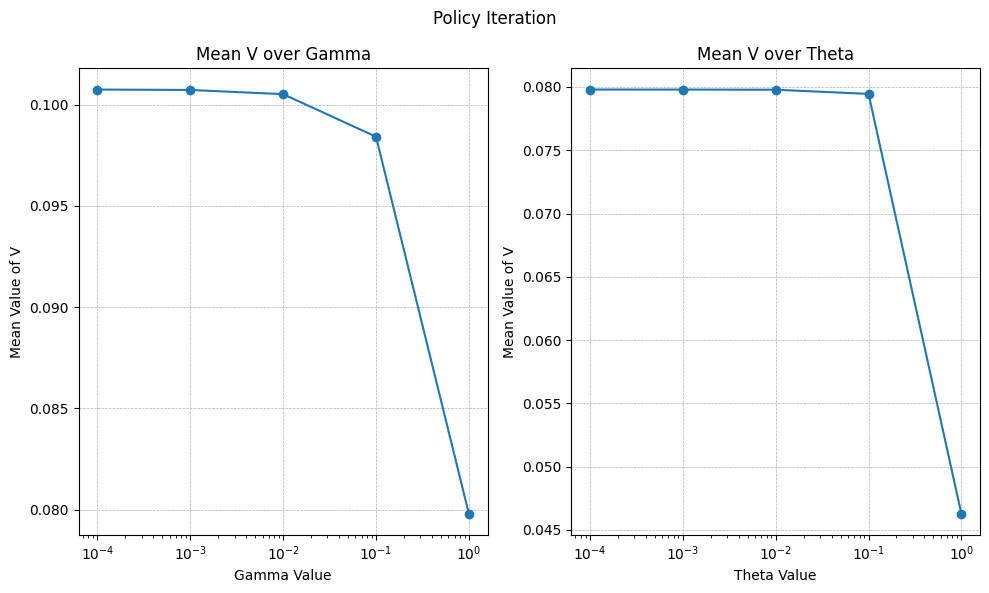

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(10, 6))
fig.suptitle('Policy Iteration')

### Gamma graph
# Define gammas
gammas = {
    0.0001: "blue",
    0.001: "orange",
    0.01: "green",
    0.1: "red",
    1.0: "purple",
}

gamma_final_mean_v = {}

for g in gammas.keys():
    bj_vi_V_value, _, _ = Planner(blackjack.P).value_iteration(gamma=g)
    gamma_final_mean_v[g] = np.mean(bj_vi_V_value)

# Plotting the final mean V for each gamma
axs[0].plot(gamma_final_mean_v.keys(), gamma_final_mean_v.values(), marker='o')
axs[0].set_title('Mean V over Gamma')
axs[0].set_xlabel('Gamma Value')
axs[0].set_ylabel('Mean Value of V')
axs[0].set_xscale('log')
axs[0].grid(True, which="major", linestyle='--', linewidth=0.5)

### Theta graph
# Define thetas
thetas = {
    0.0001: "blue",
    0.001: "orange",
    0.01: "green",
    0.1: "red",
    1.0: "purple"
}

theta_final_mean_v = {}

for t in thetas.keys():
    bj_vi_V_value, _, _ = Planner(blackjack.P).policy_iteration(theta=t)
    theta_final_mean_v[t] = np.mean(bj_vi_V_value)

# Plotting the final mean V for each theta
axs[1].plot(theta_final_mean_v.keys(), theta_final_mean_v.values(), marker='o')
axs[1].set_title('Mean V over Theta')
axs[1].set_xlabel('Theta Value')
axs[1].set_ylabel('Mean Value of V')
axs[1].set_xscale('log')
axs[1].grid(True, which="major", linestyle='--', linewidth=0.5)

#axs[0].set_ylim(0.050, 0.125)
#axs[1].set_ylim(0.050, 0.125)

#Show both plots
fig.tight_layout()
fig.show()

Value Iteration Score: 0.10074742883443832
Value Iteration Score: 0.10074742883443832
Value Iteration Score: 0.10074742883443832
Value Iteration Score: 0.10074742883443832
Value Iteration Score: 0.10074742883443832
Policy Iteration Score: 0.07979428768157959
Policy Iteration Score: 0.07979428768157959
Policy Iteration Score: 0.07976370304822922
Policy Iteration Score: 0.07972722500562668
Policy Iteration Score: 0.07504644989967346


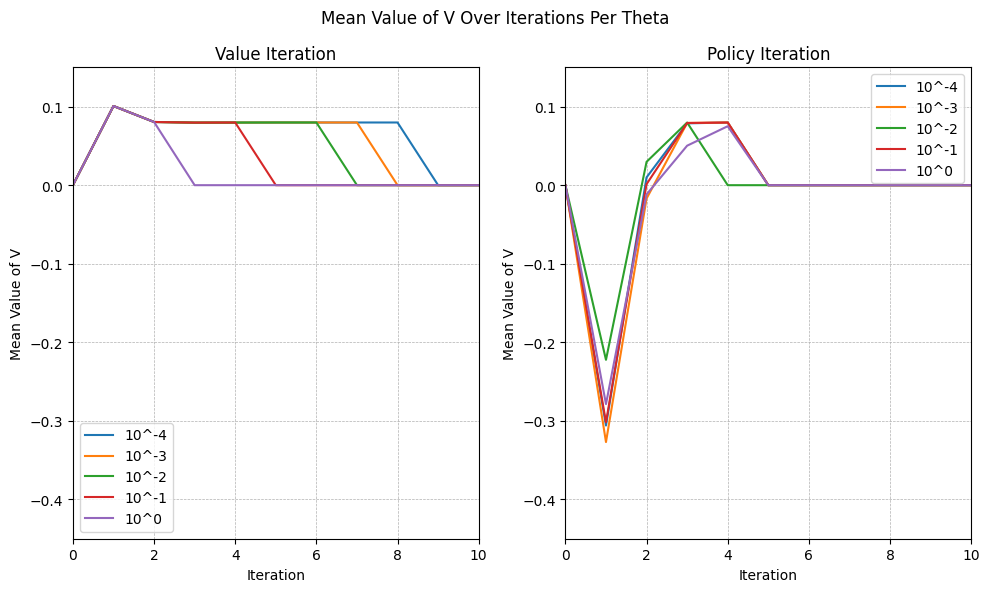

In [10]:
#Thetas
thetas = {
    0.0001: "tab:blue",
    0.001: "tab:orange",
    0.01: "tab:green",
    0.1: "tab:red",
    1.0: "tab:purple"
}

# --- Convergence Graphs ---
fig, axs = plt.subplots(1, 2, figsize=(10, 6))  # 2 rows, 2 columns
fig.suptitle('Mean Value of V Over Iterations Per Theta')

# Value Iteration Convergence
axs[0].set_title('Value Iteration')
for t, color in thetas.items():
  _, V_track, _ = Planner(blackjack.P).value_iteration(theta=t)
  mean_v = np.mean(V_track, axis=1)
  print(f"Value Iteration Score: {np.max(mean_v)}")
  axs[0].plot(mean_v, label=f'10^{int(np.log10(t))}', color=color)
axs[0].set_xlabel('Iteration')
axs[0].set_xlim(0, 10)
axs[0].set_ylabel('Mean Value of V')
axs[0].legend()

# Policy Iteration Convergence
axs[1].set_title('Policy Iteration')
for t, color in thetas.items():
  _, V_track, _ = Planner(blackjack.P).policy_iteration(theta=t)
  mean_v = np.mean(V_track, axis=1)
  print(f"Policy Iteration Score: {np.max(mean_v)}")
  axs[1].plot(mean_v, label=f'10^{int(np.log10(t))}', color=color)
axs[1].set_xlabel('Iteration')
axs[1].set_xlim(0, 10)
axs[1].set_ylabel('Mean Value of V')
axs[1].legend()

axs[0].set_ylim(-0.45, 0.15)
axs[1].set_ylim(-0.45, 0.15)

axs[0].grid(True, which="major", linestyle='--', linewidth=0.5)
axs[1].grid(True, which="major", linestyle='--', linewidth=0.5)

fig.tight_layout()
fig.show()

##Dual Value/Policy Plots

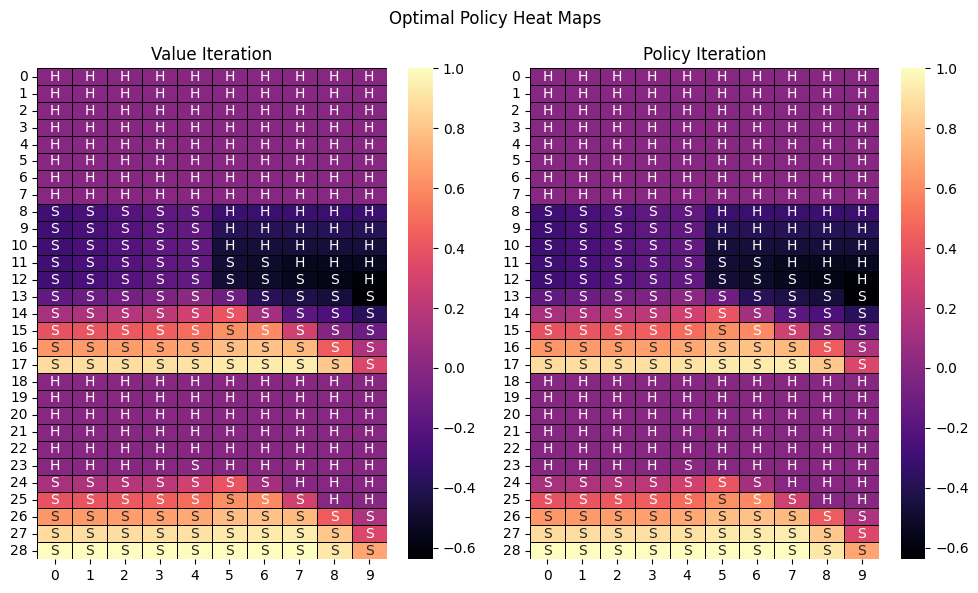

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(10, 6))
fig.suptitle('Optimal Policy Heat Maps')
###Policy heat map
blackjack_actions = {0: "S", 1: "H"}
blackjack_map_size=(29, 10)

@add_to(Plots)
@staticmethod
def modified_plot_policy(title, policy, value_function, ax=None): # Add ax parameter
  #Get formatted state values and policy map
  val_max, policy_map = Plots.get_policy_map(policy, value_function, blackjack_actions, blackjack_map_size)

  #Plot the policy learned on the specified ax
  sns.heatmap(
      val_max,
      annot=policy_map,
      fmt="",
      cmap=sns.color_palette("magma", as_cmap=True),
      linewidths=0.7,
      linecolor="black",
      ax=ax # Pass ax to sns.heatmap
  ).set(title=f"{title}")

bj_vi_title="Value Iteration"
bj_vi_start_time = time.time()
bj_vi_V_value, bj_vi_V_track_value, bj_vi_pi_value = Planner(blackjack.P).value_iteration(gamma=0.0001, theta=0.1)
bj_vi_end_time = time.time()
bj_vi_execution_time = bj_vi_end_time - bj_vi_start_time
Plots.modified_plot_policy(bj_vi_title, bj_vi_pi_value, bj_vi_V_value, ax=axs[0]) # Pass axs[1] to the function

bj_pi_title="Policy Iteration"
bj_pi_start_time = time.time()
bj_pi_V_value, bj_pi_V_track_value, bj_pi_pi_value = Planner(blackjack.P).policy_iteration(gamma=0.0001, theta=0.0001)
bj_pi_end_time = time.time()
bj_pi_execution_time = bj_pi_end_time - bj_pi_start_time
Plots.modified_plot_policy(bj_pi_title, bj_pi_pi_value, bj_pi_V_value, ax=axs[1]) # Pass axs[1] to the function

fig.tight_layout()
fig.show()

In [12]:
mean_score_vi = np.mean(bj_vi_V_value)
mean_score_pi = np.mean(bj_pi_V_value)

print("Value Iteration:")
print("Optimal Policy:", bj_vi_pi_value)
print("Final Mean Score:", mean_score_vi)

print("\nPolicy Iteration:")
print("Optimal Policy:", bj_pi_pi_value)
print("Final Mean Score:", mean_score_pi)

if bj_vi_pi_value == bj_pi_pi_value:
    print("\nOptimal policies are the same.")
else:
    print("\nOptimal policies are different.")
    for key in bj_vi_pi_value:
        if bj_vi_pi_value[key] != bj_pi_pi_value[key]:
            print(f"Key: {key}, Value Iteration: {bj_vi_pi_value[key]}, Policy Iteration: {bj_pi_pi_value[key]}")

Value Iteration:
Optimal Policy: {0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1, 17: 1, 18: 1, 19: 1, 20: 1, 21: 1, 22: 1, 23: 1, 24: 1, 25: 1, 26: 1, 27: 1, 28: 1, 29: 1, 30: 1, 31: 1, 32: 1, 33: 1, 34: 1, 35: 1, 36: 1, 37: 1, 38: 1, 39: 1, 40: 1, 41: 1, 42: 1, 43: 1, 44: 1, 45: 1, 46: 1, 47: 1, 48: 1, 49: 1, 50: 1, 51: 1, 52: 1, 53: 1, 54: 1, 55: 1, 56: 1, 57: 1, 58: 1, 59: 1, 60: 1, 61: 1, 62: 1, 63: 1, 64: 1, 65: 1, 66: 1, 67: 1, 68: 1, 69: 1, 70: 1, 71: 1, 72: 1, 73: 1, 74: 1, 75: 1, 76: 1, 77: 1, 78: 1, 79: 1, 80: 0, 81: 0, 82: 0, 83: 0, 84: 0, 85: 1, 86: 1, 87: 1, 88: 1, 89: 1, 90: 0, 91: 0, 92: 0, 93: 0, 94: 0, 95: 1, 96: 1, 97: 1, 98: 1, 99: 1, 100: 0, 101: 0, 102: 0, 103: 0, 104: 0, 105: 1, 106: 1, 107: 1, 108: 1, 109: 1, 110: 0, 111: 0, 112: 0, 113: 0, 114: 0, 115: 0, 116: 0, 117: 1, 118: 1, 119: 1, 120: 0, 121: 0, 122: 0, 123: 0, 124: 0, 125: 0, 126: 0, 127: 0, 128: 0, 129: 1, 130: 0, 131: 0, 132: 0, 133: 0, 134:

1.0
1.0


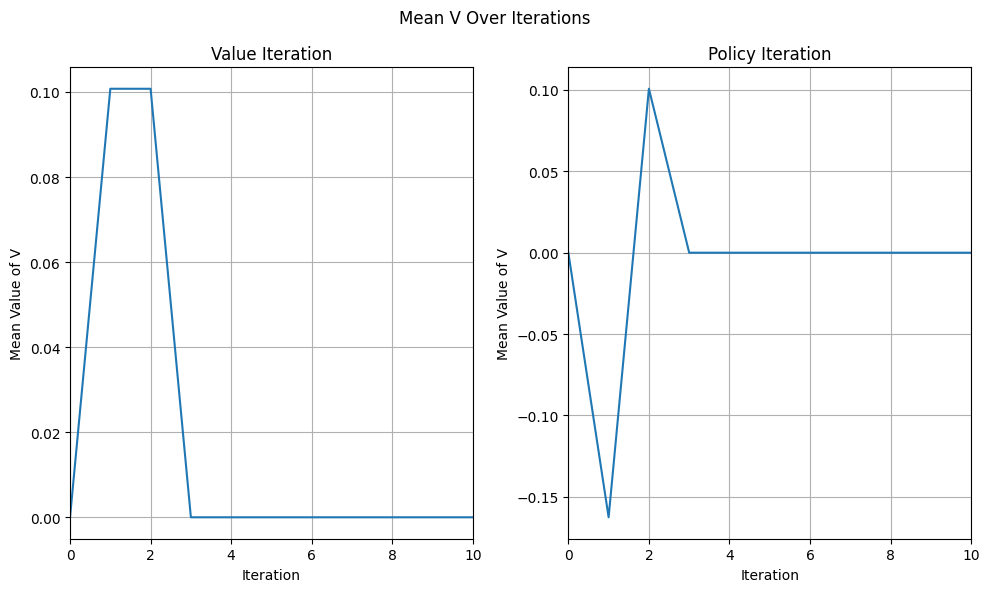

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(10, 6))
fig.suptitle('Mean V Over Iterations')

bj_vi_title="Value Iteration"

#Plot
mean_V_over_iterations = np.mean(bj_vi_V_track_value, axis=1)
axs[0].plot(mean_V_over_iterations)
axs[0].set_xlabel('Iteration')
axs[0].set_ylabel('Mean Value of V')
axs[0].set_xlim(0,10)
#axs[0].set_ylim(-0.15, 0.15)
axs[0].set_title('Value Iteration')
axs[0].grid(True)

bj_pi_title="Policy Iteration"
mean_V_over_iterations = np.mean(bj_pi_V_track_value, axis=1)
axs[1].plot(mean_V_over_iterations)
axs[1].set_xlim(0,10)
#axs[1].set_ylim(-0.15, 0.15)
axs[1].set_xlabel('Iteration')
axs[1].set_ylabel('Mean Value of V')
axs[1].set_title('Policy Iteration')
axs[1].grid(True)

print(np.max(bj_vi_V_track_value))
print(np.max(bj_pi_V_track_value))

fig.tight_layout()
fig.show()

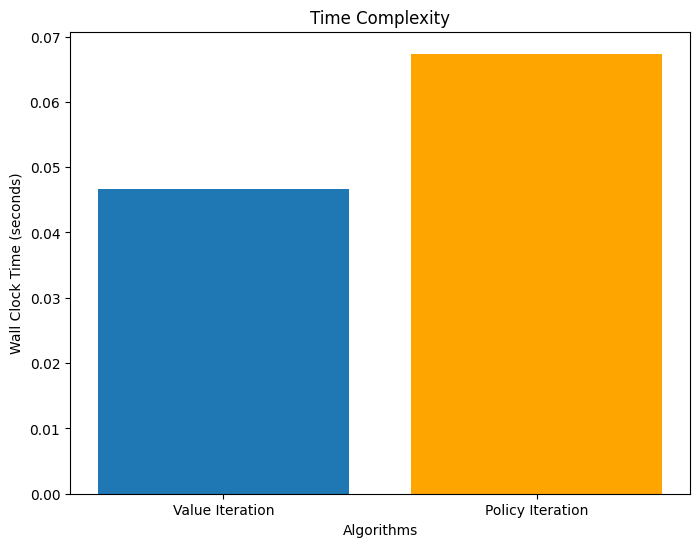

Value Iteration Execution Time: 0.046675682067871094 seconds
Policy Iteration Execution Time: 0.06736969947814941 seconds


In [14]:
# Sample run times (replace with your actual data)
algorithms = ['Value Iteration', 'Policy Iteration']
run_times = [bj_vi_execution_time, bj_pi_execution_time]

plt.figure(figsize=(8, 6))
plt.bar(algorithms, run_times, color=['tab:blue', 'orange'])
plt.xlabel("Algorithms")
plt.ylabel("Wall Clock Time (seconds)")
plt.title("Time Complexity")
plt.show()

print(f"Value Iteration Execution Time: {bj_vi_execution_time} seconds")
print(f"Policy Iteration Execution Time: {bj_pi_execution_time} seconds")